In [ ]:
!wget http://www.atarimania.com/roms/Roms.rar
!unrar e Roms.rar
!unzip ROMS.zip
!python -m atari_py.import_roms /content/ROMS
!pip install gym-retro
!pip install baselines

--2021-06-23 08:49:24--  http://www.atarimania.com/roms/Roms.rar
Resolving www.atarimania.com (www.atarimania.com)... 195.154.81.199
Connecting to www.atarimania.com (www.atarimania.com)|195.154.81.199|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11128004 (11M) [application/x-rar-compressed]
Saving to: ‘Roms.rar’

Roms.rar            100%[===================>]  10.61M   636KB/s    in 18s     

2021-06-23 08:49:42 (614 KB/s) - ‘Roms.rar’ saved [11128004/11128004]


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from Roms.rar

Extracting  HC ROMS.zip                                                   36%  OK 
Extracting  ROMS.zip                                                      74% 99%  OK 
All OK
Archive:  ROMS.zip
   creating: ROMS/
  inflating: ROMS/128 in 1 Game Select ROM (128 in 1) (Unknown) ~.bin  
  inflating: ROMS/2 Pak Special - Cavern Blaster, City War (1992) (HES) (773-867) (PAL).bin  
  infl

## Setup

In [ ]:
from baselines.common.atari_wrappers import make_atari, wrap_deepmind
import gym
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Configuration paramaters for the whole setup
seed = 42
gamma = 0.99  # Discount factor for past rewards
epsilon = 1.0  # Epsilon greedy parameter
epsilon_min = 0.1  # Minimum epsilon greedy parameter
epsilon_max = 1.0  # Maximum epsilon greedy parameter
epsilon_interval = (
    epsilon_max - epsilon_min
)  # Rate at which to reduce chance of random action being taken
batch_size = 32  # Size of batch taken from replay buffer
max_steps_per_episode = 10000

# Use the Baseline Atari environment because of Deepmind helper functions
env = gym.make("SpaceInvaders-v0")

# Warp the frames, grey scale, stake four frame and scale to smaller ratio
env = wrap_deepmind(env, frame_stack=True, scale=True)
env.seed(seed)

[42, 742738649]

## Implement the Deep Q-Network

This network learns an approximation of the Q-table, which is a mapping between
the states and actions that an agent will take. For every state we'll have four
actions, that can be taken. The environment provides the state, and the action
is chosen by selecting the larger of the four Q-values predicted in the output layer.

In [ ]:
num_actions = env.action_space.n
print(env.env.get_action_meanings())

def create_q_model():
    # Network defined by the Deepmind paper
    inputs = layers.Input(shape=(84, 84, 4,))

    # Convolutions on the frames on the screen
    layer1 = layers.Conv2D(32, 8, strides=4, activation="relu")(inputs)
    layer2 = layers.Conv2D(64, 4, strides=2, activation="relu")(layer1)
    layer3 = layers.Conv2D(64, 3, strides=1, activation="relu")(layer2)

    layer4 = layers.Flatten()(layer3)

    layer5 = layers.Dense(512, activation="relu")(layer4)
    action = layers.Dense(num_actions, activation="linear")(layer5)

    return keras.Model(inputs=inputs, outputs=action)


# The first model makes the predictions for Q-values which are used to
# make a action.
model = create_q_model()
# Build a target model for the prediction of future rewards.
# The weights of a target model get updated every 10000 steps thus when the
# loss between the Q-values is calculated the target Q-value is stable.
model_target = create_q_model()


['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']


In [ ]:
import matplotlib.pyplot as plt

def plot_mean(episodes, cummean, xlabel, ylabel, title):
    fig = plt.figure(figsize=(12, 6))
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.plot(episodes, cummean, figure=fig)
    plt.show()

## Train

running reward: 3.72 at episode 39, frame count 10000
running reward: 3.51 at episode 82, frame count 20000
running reward: 3.20 at episode 132, frame count 30000
running reward: 3.11 at episode 179, frame count 40000
running reward: 3.03 at episode 225, frame count 50000
running reward: 2.98 at episode 272, frame count 60000
running reward: 2.95 at episode 320, frame count 70000
running reward: 3.05 at episode 360, frame count 80000
Solved with running reward 3.075 at episode 400!


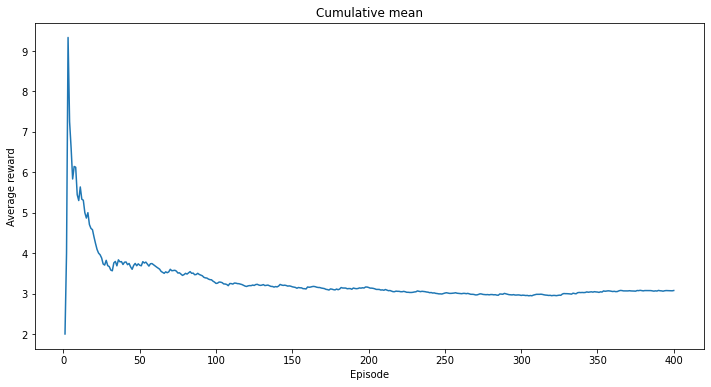

In [ ]:
# In the Deepmind paper they use RMSProp however then Adam optimizer
# improves training time
optimizer = keras.optimizers.Adam(learning_rate=0.00025, clipnorm=1.0)

# Experience replay buffers
action_history = []
state_history = []
state_next_history = []
rewards_history = []
done_history = []
episode_reward_history = []
cummean = []
running_reward = 0
episode_count = 0
frame_count = 0
# Number of frames to take random action and observe output
epsilon_random_frames = 35000
# Number of frames for exploration
epsilon_greedy_frames = 1000000.0
# Maximum replay length
# Note: The Deepmind paper suggests 1000000 however this causes memory issues
max_memory_length = 70000
# Train the model after 4 actions
update_after_actions = 4
# How often to update the target network
update_target_network = 10000
# Using huber loss for stability
loss_function = keras.losses.Huber()

while True:  # Run until solved
    state = np.array(env.reset())
    episode_reward = 0

    for timestep in range(1, max_steps_per_episode):
        # env.render(); Adding this line would show the attempts
        # of the agent in a pop up window.
        frame_count += 1

        # Use epsilon-greedy for exploration
        if frame_count < epsilon_random_frames or epsilon > np.random.rand(1)[0]:
            # Take random action
            action = np.random.choice(num_actions)
        else:
            # Predict action Q-values
            # From environment state
            state_tensor = tf.convert_to_tensor(state)
            state_tensor = tf.expand_dims(state_tensor, 0)
            action_probs = model(state_tensor, training=False)
            # Take best action
            action = tf.argmax(action_probs[0]).numpy()

        # Decay probability of taking random action
        epsilon -= epsilon_interval / epsilon_greedy_frames
        epsilon = max(epsilon, epsilon_min)

        # Apply the sampled action in our environment
        state_next, reward, done, _ = env.step(action)
        state_next = np.array(state_next)

        episode_reward += reward

        # Save actions and states in replay buffer
        action_history.append(action)
        state_history.append(state)
        state_next_history.append(state_next)
        done_history.append(done)
        rewards_history.append(reward)
        state = state_next

        # Update every fourth frame and once batch size is over 32
        if frame_count % update_after_actions == 0 and len(done_history) > batch_size:

            # Get indices of samples for replay buffers
            indices = np.random.choice(range(len(done_history)), size=batch_size)

            # Using list comprehension to sample from replay buffer
            state_sample = np.array([state_history[i] for i in indices])
            state_next_sample = np.array([state_next_history[i] for i in indices])
            rewards_sample = [rewards_history[i] for i in indices]
            action_sample = [action_history[i] for i in indices]
            done_sample = tf.convert_to_tensor(
                [float(done_history[i]) for i in indices]
            )

            # Build the updated Q-values for the sampled future states
            # Use the target model for stability
            future_rewards = model_target.predict(state_next_sample)
            # Q value = reward + discount factor * expected future reward
            updated_q_values = rewards_sample + gamma * tf.reduce_max(
                future_rewards, axis=1
            )

            # If final frame set the last value to -1
            updated_q_values = updated_q_values * (1 - done_sample) - done_sample

            # Create a mask so we only calculate loss on the updated Q-values
            masks = tf.one_hot(action_sample, num_actions)

            with tf.GradientTape() as tape:
                # Train the model on the states and updated Q-values
                q_values = model(state_sample)

                # Apply the masks to the Q-values to get the Q-value for action taken
                q_action = tf.reduce_sum(tf.multiply(q_values, masks), axis=1)
                # Calculate loss between new Q-value and old Q-value
                loss = loss_function(updated_q_values, q_action)

            # Backpropagation
            grads = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))

        if frame_count % update_target_network == 0:
            # update the the target network with new weights
            model_target.set_weights(model.get_weights())
            # Log details
            template = "running reward: {:.2f} at episode {}, frame count {}"
            print(template.format(running_reward, episode_count, frame_count))

        # Limit the state and reward history
        if len(rewards_history) > max_memory_length:
            del rewards_history[:1]
            del state_history[:1]
            del state_next_history[:1]
            del action_history[:1]
            del done_history[:1]

        if done:
            break

    # Update running reward
    episode_reward_history.append(episode_reward)
    running_reward = np.mean(episode_reward_history)
    cummean.append(running_reward)

    episode_count += 1

    if episode_count == 400:  # Condition to consider the task solved
        print("Solved with running reward {} at episode {}!".format(running_reward, episode_count))
        episodes = range(1, episode_count + 1)
        plot_mean(episodes, cummean, "Episode", "Average reward", "Cumulative mean")
        break

In [ ]:
# serialize model to JSON
model_json = model.to_json()
with open("dqn_spaceinvaders_model.json", "w") as json_file:
    json_file.write(model_json)

# serialize weights to HDF5
model.save_weights("dqn_spaceinvaders.h5")
print("Saved model to disk")

Saved model to disk


## Test

In [ ]:
# load json and create model
json_file = open('dqn_spaceinvaders_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = keras.models.model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights("dqn_spaceinvaders.h5")
print("Loaded model from disk")

Loaded model from disk


In [ ]:
import cv2
from IPython import display as ipythondisplay

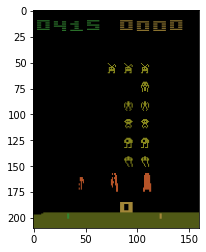

In [ ]:
state = np.array(env.reset())
episode_reward = 0

prev_screen = env.render(mode='rgb_array')
# plt.imshow(prev_screen)

fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('output.avi', fourcc, 20.0, prev_screen.shape[1::-1])

for iters in range(10):
    for timestep in range(1, max_steps_per_episode):
        # show the attempts  the agent in a pop up window.
        screen = env.render(mode='rgb_array')

        # write the flipped frame
        out.write(screen)

        #    
        plt.imshow(screen)
        ipythondisplay.clear_output(wait=True)
        ipythondisplay.display(plt.gcf())
        
        # Predict action Q-values
        # From environment state
        state_tensor = tf.convert_to_tensor(state)
        state_tensor = tf.expand_dims(state_tensor, 0)
        action_probs = model(state_tensor, training=False)
        # Take best action
        action = tf.argmax(action_probs[0]).numpy()

        # Apply the sampled action in our environment
        state, reward, done, _ = env.step(action)
        state = np.array(state)

        episode_reward += reward

        if done:
            break

ipythondisplay.clear_output(wait=True)
env.close()
out.release()